In [30]:
import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import math
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [103]:
# load dataset
dataset = pd.read_csv('DataSets/beehive_9803.csv', usecols=[4,7,8,9], header=0)
dataset.fillna(0, inplace=True)
values = dataset.values

# integer encode direction
#encoder = LabelEncoder()
encoder = LabelEncoder()
#values[:,0] = encoder.fit_transform(values[:,0])
#values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[]], axis=1, inplace=True)
print(reframed.head())
colunas = values

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  \
2   0.481210   0.652968   0.635696   0.954545   0.624198   0.616438   
3   0.624198   0.616438   0.635266   0.954545   0.246563   0.602740   
4   0.246563   0.602740   0.635180   0.954545   0.356554   0.652968   
5   0.356554   0.652968   0.631570   0.886363   0.054079   0.753425   
6   0.054079   0.753425   0.632687   0.977272   0.128323   0.890411   

   var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)   var4(t)  
2   0.635266   0.954545  0.246563  0.602740  0.635180  0.954545  
3   0.635180   0.954545  0.356554  0.652968  0.631570  0.886363  
4   0.631570   0.886363  0.054079  0.753425  0.632687  0.977272  
5   0.632687   0.977272  0.128323  0.890411  0.628046  0.954545  
6   0.628046   0.954545  0.000000  0.908676  0.631914  0.931818  


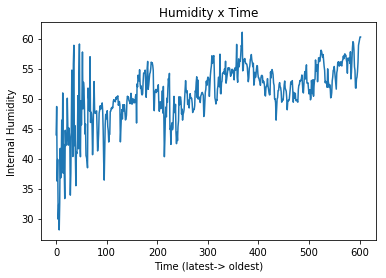

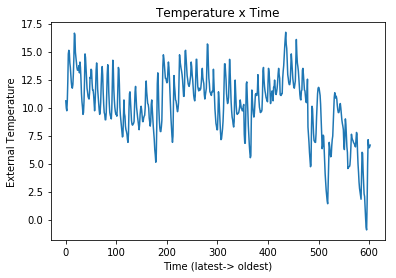

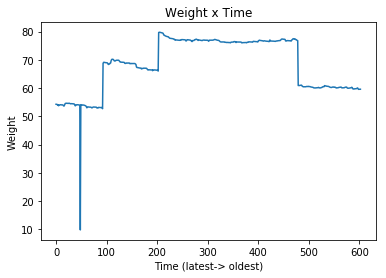

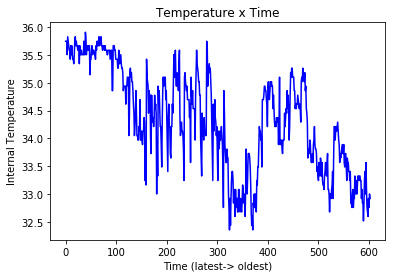

In [104]:
plt.plot(values[:,0])
plt.title("Humidity x Time")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Internal Humidity")
plt.show()

plt.plot(values[:,1])
plt.title("Temperature x Time")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("External Temperature")
plt.show()

plt.plot(values[:,2])
plt.title("Weight x Time")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Weight")
plt.show()

plt.plot(values[:,3], color='blue')
plt.title("Temperature x Time")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Internal Temperature")
plt.show()

In [105]:
# split into train and test sets
values = reframed.values

# split into input and outputs
train_X, train_y = values[:, :-1], values[:, -1]
print(train_X)
#REOLHAR ISSO AQUI
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print(train_X.shape, train_y.shape)

[[0.48120975 0.65296805 0.6356956  ... 0.24656272 0.6027397  0.6351799 ]
 [0.62419796 0.6164383  0.6352658  ... 0.35655355 0.65296805 0.6315699 ]
 [0.24656272 0.6027397  0.6351799  ... 0.05407882 0.75342464 0.63268733]
 ...
 [0.9340055  0.456621   0.7112468  ... 0.95966995 0.41552514 0.71120375]
 [0.94775426 0.42465752 0.71133274 ... 0.9761685  0.42009133 0.71184844]
 [0.95966995 0.41552514 0.71120375 ... 0.9761685  0.42922375 0.7117625 ]]
(601, 1, 11) (601,)


In [106]:
#configure the learning process, which is done via the compile method. 
#It receives three arguments:

#An optimizer. This could be the string identifier of an existing optimizer 
#A loss function. This is the objective that the model will try to minimize. 
#A list of metrics. For any classification problem you will want to set this to metrics=['accuracy'].


In [107]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.

In [128]:
# design network
model = Sequential()
#Input shape = (Timestamp = none(qualquer quantidade de entrada), Number of features)
model.add(LSTM(50, input_shape=(None, train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(10,kernel_initializer="normal",activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
#model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss = ['mse'], metrics=['mse','mae', 'mape', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50)                12400     
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_33 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 12,921
Trainable params: 12,921
Non-trainable params: 0
_________________________________________________________________


In [129]:
#The model.evaluate function predicts the output for the given input and 
#then computes the metrics function specified in the model.compile and ]
#based on y_true and y_pred and returns the computed metric value as the output.

#The model.predict just returns back the y_pred

#So if you use model.predict and then compute the metrics yourself,
#the computed metric value should turn out to be the same as model.evaluate

In [130]:
#FIT -> Trains the model for a given number of epochs (iterations on a dataset).
#batch_size: Number of samples per gradient update. batch_size will default to 32.

In [150]:
# fit network
#history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_split = 0.1, verbose=2, callbacks=[PlotLossesKeras()], shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_split = 0.1, verbose=2, callbacks=[PlotLossesKeras()], shuffle=False)

print(model.summary())
#batch size - tamanho de amostras que ele vai pegar 
#e separar e depois faz o back propagation em cada 1

KeyboardInterrupt: 

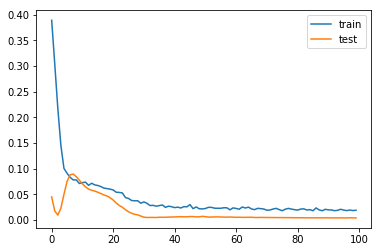

In [132]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [133]:
print(model.metrics_names)
score = model.evaluate(train_X, train_y, batch_size=256)
score

['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'acc']
601/601 [==============================] - 0s 17us/step


[0.010383263855596103,
 0.010383263855596103,
 0.0717540387553899,
 483545.16126771696,
 0.004991680532445923]

In [134]:
# generate predictions for training
trainPredict = model.predict(train_X)


In [135]:
# generate predictions for training
trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
array = colunas[:,3]
array = np.reshape(array,(603, 1)) 
#array1 = np.reshape(train_y,(603, 1)) 
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit_transform(array)
trainPredict = sc.inverse_transform(trainPredict)
print(trainPredict)


Train Score: 0.10 RMSE
[[35.476315]
 [35.48542 ]
 [35.49093 ]
 [35.55485 ]
 [35.625175]
 [35.62193 ]
 [35.604137]
 [35.560654]
 [35.502983]
 [35.52352 ]
 [35.49451 ]
 [35.48093 ]
 [35.47409 ]
 [35.4246  ]
 [35.4736  ]
 [35.484077]
 [35.5523  ]
 [35.60225 ]
 [35.60138 ]
 [35.57755 ]
 [35.558487]
 [35.536095]
 [35.505657]
 [35.514187]
 [35.511097]
 [35.516705]
 [35.47604 ]
 [35.512367]
 [35.54771 ]
 [35.474365]
 [35.406757]
 [35.355484]
 [35.37185 ]
 [35.367897]
 [35.2837  ]
 [35.40617 ]
 [35.49749 ]
 [35.493057]
 [35.592278]
 [35.614624]
 [35.52478 ]
 [35.488968]
 [35.462494]
 [35.44998 ]
 [35.46056 ]
 [35.378735]
 [35.47444 ]
 [35.447132]
 [35.440117]
 [35.41579 ]
 [35.45194 ]
 [35.44204 ]
 [35.39494 ]
 [35.409016]
 [35.397354]
 [35.39709 ]
 [35.398235]
 [35.409084]
 [35.42875 ]
 [35.511482]
 [35.544888]
 [35.554573]
 [35.518837]
 [35.454052]
 [35.445103]
 [35.4572  ]
 [35.42832 ]
 [35.412853]
 [35.486298]
 [35.52064 ]
 [35.53125 ]
 [35.532986]
 [35.517067]
 [35.471107]
 [35.42743 ]
 [

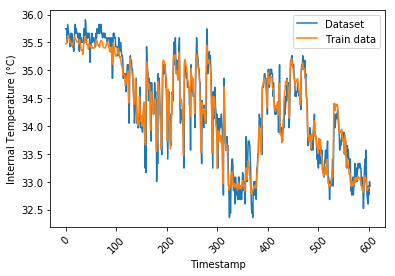

In [136]:
fig, ax= plt.subplots()
plt.plot(colunas[:,3], label='Dataset')
plt.plot(trainPredict, label='Train data')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Timestamp",
       ylabel="Internal Temperature (°C)",
       title="");
plt.legend()
#plt.gcf().autofmt_xdate()
plt.show()

In [137]:
dataset_test = pd.read_csv('DataSets/beehive_9837.csv', usecols=[4,7,8,9], header=0)
dataset_test.fillna(0, inplace=True)
values_test = dataset_test.values

In [138]:
encoder = LabelEncoder()
#values_test[:,0] = encoder.fit_transform(values_test[:,0])
#values_test[:,1] = encoder.fit_transform(values_test[:,1])
# ensure all data is float
values_test = values_test.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values_test)
# frame as supervised learning
reframed_test = series_to_supervised(scaled, 2, 1)
# drop columns we don't want to predict
#reframed_test.drop(reframed_test.columns[[0,1,3,5,6]], axis=1, inplace=True)
print(reframed_test.head())
colunas_test = values_test

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  \
2   0.033672   0.666667   0.782353   0.816514   0.024778   0.637566   
3   0.024778   0.637566   0.783735   0.908257   0.012706   0.600529   
4   0.012706   0.600529   0.784598   0.949541   0.010165   0.582011   
5   0.010165   0.582011   0.787188   0.972477   0.013342   0.582011   
6   0.013342   0.582011   0.788224   0.958716   0.009530   0.568783   

   var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)   var4(t)  
2   0.783735   0.908257  0.012706  0.600529  0.784598  0.949541  
3   0.784598   0.949541  0.010165  0.582011  0.787188  0.972477  
4   0.787188   0.972477  0.013342  0.582011  0.788224  0.958716  
5   0.788224   0.958716  0.009530  0.568783  0.790037  0.954129  
6   0.790037   0.954129  0.006353  0.555556  0.790123  0.949541  


In [139]:
# split into train and test sets
values_test = reframed_test.values

# split into input and outputs
test_X, test_y = values_test[:, :-1], values_test[:, -1]
print(test_X)

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# reshape input to be 3D [samples, timesteps, features]
print(test_X.shape, test_y.shape)


[[0.03367217 0.6666666  0.7823534  ... 0.01270648 0.6005291  0.784598  ]
 [0.02477763 0.63756615 0.7837347  ... 0.01016518 0.58201057 0.78718805]
 [0.01270648 0.6005291  0.784598   ... 0.0133418  0.58201057 0.7882241 ]
 ...
 [0.84371024 0.36243385 0.8864715  ... 0.8659466  0.37566137 0.88690317]
 [0.87229985 0.3703704  0.88664424 ... 0.8424396  0.37301588 0.8886299 ]
 [0.8659466  0.37566137 0.88690317 ... 0.8595934  0.35978836 0.8893205 ]]
(1454, 1, 11) (1454,)


In [140]:
# make a prediction
testPredict = model.predict(test_X)

In [141]:
# generate predictions for training
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:,0]))
print('Train Score: %.2f RMSE' % (testScore))
array = colunas_test[:,3]
array = np.reshape(array,(1456, 1)) 
sc = MinMaxScaler(feature_range=(0, 1))
sc.fit_transform(array)
testPredict = sc.inverse_transform(testPredict)


print(testPredict)


Train Score: 0.09 RMSE
[[34.3132  ]
 [34.627995]
 [34.759586]
 ...
 [22.131306]
 [22.099493]
 [22.102802]]


In [142]:
print(model.metrics_names)
score = model.evaluate(test_X, test_y, batch_size=256)
score

['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'acc']
1454/1454 [==============================] - 0s 12us/step


[0.007469676485595177,
 0.007469676485595177,
 0.07617374158565575,
 83653.14673288127,
 0.0006877579066538581]

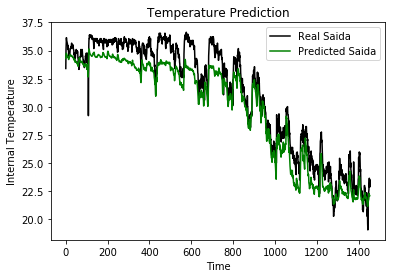

In [143]:
plt.plot(colunas_test[:,3], color = 'black', label = 'Real Saida')
plt.plot(testPredict, color = 'green', label = 'Predicted Saida')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Internal Temperature')
plt.legend()
plt.show()